In [1]:
# Import packages
import xarray as xr
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np

In [26]:
# Specify the path to the data on flyingfish
rootdir = '/local/ss23/GFDL_LEs/'
# Specify which experiment you want to look at
experiment = 'OCN/METABOLIC_INDEX/RCP85'
# Specify the file name
filename = 'MI_irr_0.1Wm2_1x1_ens101_1950_2100.nc'
# The combination of these defines the path
path = rootdir+experiment+'/'+filename
ds = xr.open_dataset(path).rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})

filename = 'MI_irr_0.1Wm2_1x1_ens*_1950_2100.nc'
path = rootdir+experiment+'/'+filename
# Load the file using xarray

<xarray.Dataset>
Dimensions:   (time: 1812, xt_ocean: 360, yt_ocean: 180)
Coordinates:
  * time      (time) object 1950-01-31 00:00:00 ... 2100-12-31 00:00:00
  * yt_ocean  (yt_ocean) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xt_ocean  (xt_ocean) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    MI        (time, yt_ocean, xt_ocean) float32 ...
Attributes:
    author:     Karl Stein
    history:    Calculated with /proj/shared_data/ESM2M/scripts/calc_ESM2M_ir...
    reference:  Penn et al., Science 362, eaat1327 (2018)

In [32]:
ds_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='TIME', combine='nested').rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})
ds

<xarray.Dataset>
Dimensions:   (time: 1812, xt_ocean: 360, yt_ocean: 180)
Coordinates:
  * time      (time) object 1950-01-31 00:00:00 ... 2100-12-31 00:00:00
  * yt_ocean  (yt_ocean) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * xt_ocean  (xt_ocean) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    MI        (time, yt_ocean, xt_ocean) float32 ...
Attributes:
    author:     Karl Stein
    history:    Calculated with /proj/shared_data/ESM2M/scripts/calc_ESM2M_ir...
    reference:  Penn et al., Science 362, eaat1327 (2018)

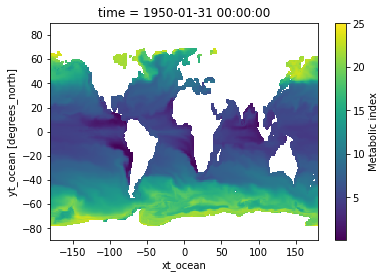

In [22]:
ds['MI'].isel(time=0).plot()

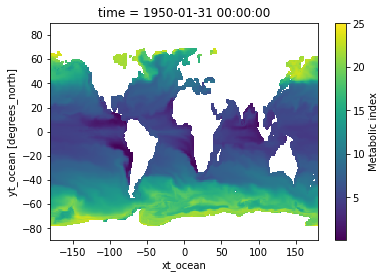

In [34]:
ds_all['MI'].isel(time=0).plot()

In [12]:
def plot_mi(date):

    # Specify the projection you want to use
    crs = ccrs.PlateCarree()

    # Create a figure and axes using matplotlib
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs})

    X = ds['xt_ocean']
    Y = ds['yt_ocean']
    Z = (ds['MI']).sel(TIME=date).squeeze() # .squeeze() gets rid of unnecessary (singular) dimensions
    Z, X = add_cyclic_point(Z,coord=X)

    im = ax.contourf(X,Y,Z,transform=crs)

    # Add a land mask to your plot, as well as grid lines and coastlines
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.gridlines()
    ax.coastlines()

    # Give your plot a title
    ax.set_title('1a. Metabolic Index, ' + date,fontsize=14,loc='left')

    # Finally, add a colorbar
    cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
    # cbar.set_label('$^\circ\,MI$',fontsize=12)

In [46]:
ds_mean = ds_all.groupby('time.year').mean(dim='time')
ds_mean

,Array,Chunk
Bytes,39.14 MB,259.20 kB
Shape,"(151, 180, 360)","(1, 180, 360)"
Count,11113 Tasks,151 Chunks
Type,float32,numpy.ndarray


/home/aos/ystochel/miniconda3/envs/esm2m/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


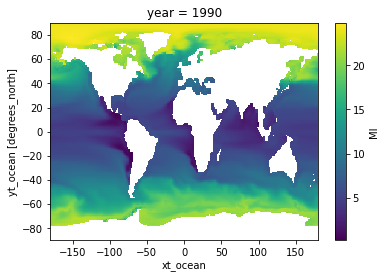

In [44]:
ds_mean.MI.sel(year=1990).plot()

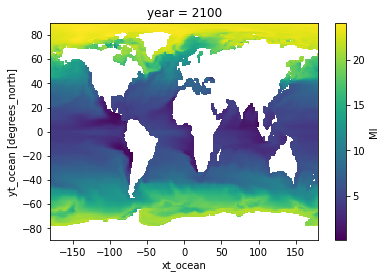

In [48]:
ds_mean.MI.sel(year=2100).plot()

In [9]:
# Load the area data
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
# Fix a slight mismatch in the area LAT and LON coordinates
# Set them to be the same as the temperature dataset 
area = area.assign_coords({'xt_ocean':ds['xt_ocean'],'yt_ocean':ds['yt_ocean']})

In [35]:
# Calculate the area-weighted mean sea-surface temperature
# This is very easy with xarray, using the .sum() command

# First work out where this land
oceanmask = np.isfinite(ds_all['MI'].isel(time=0).squeeze())
# Set the area variable to nan everwhere there is land, using .where()
area_masked = area.where(oceanmask,np.nan)
# Take the area-weighted mean
mi_mean = (ds_all['MI']*area_masked).sum(['xt_ocean','yt_ocean'])/(area_masked.sum(['xt_ocean','yt_ocean']))

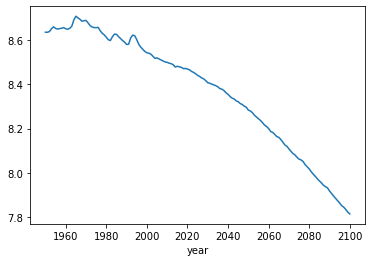

In [37]:
mi_mean.groupby('time.year').mean().plot()

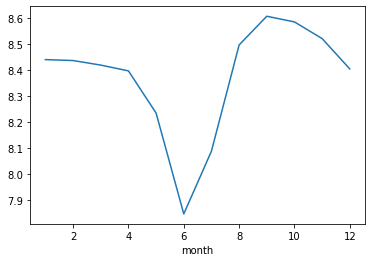

In [49]:
mi_mean.groupby('time.month').mean().plot()

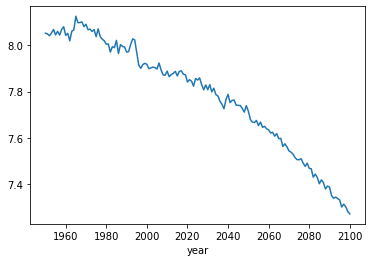

In [50]:
mi_mean.groupby('time.year').min().plot()

Text(0.5, 0, 'Month')

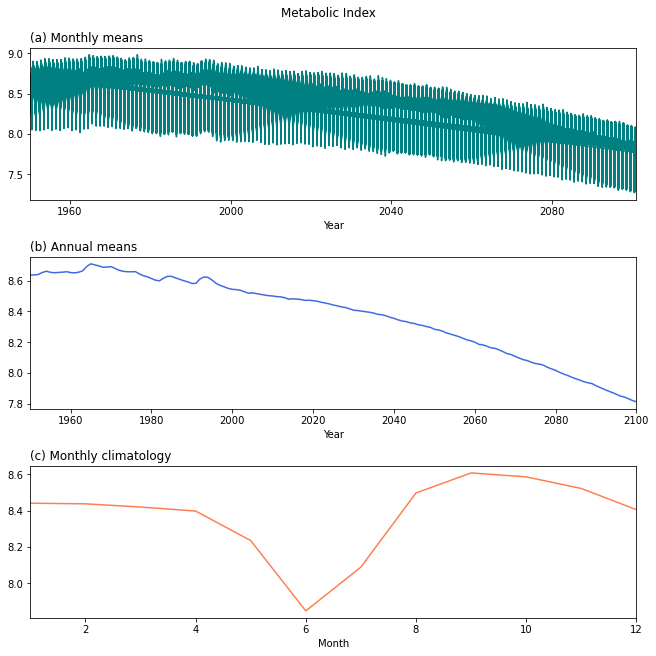

In [57]:
fig,(ax0,ax1,ax2) = plt.subplots(figsize=(9,9),nrows=3,constrained_layout=True)
fig.suptitle('Metabolic Index') # Specify a figure title
# Monthly means
ax0.plot(mi_mean['time'],mi_mean,color='teal')
ax0.set_title('(a) Monthly means',loc='left')
ax0.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax0.set_xlabel('Year')
# Annual means
#   * use np.unique() to pick out an array of years
ax1.plot(np.unique(mi_mean['time.year']),mi_mean.groupby('time.year').mean(),color='royalblue')
ax1.set_title('(b) Annual means',loc='left')
ax1.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax1.set_xlabel('Year')
# Monthly climatology
#   * use np.unique() to pick out an array of months
ax2.plot(np.unique(mi_mean['time.month']),mi_mean.groupby('time.month').mean(),color='coral')
ax2.set_title('(c) Monthly climatology',loc='left')
ax2.autoscale(enable=True,axis='x',tight=True) # Make x-axis "tight"
ax2.set_xlabel('Month')